In [1]:
import numpy as np
import scipy.io as scio
import time

In [2]:
#导入数据
offline_data = scio.loadmat('offline_data_random.mat')
online_data  = scio.loadmat('online_data.mat')
offline_location,offline_rss = offline_data['offline_location'],offline_data['offline_rss']
trace,rss = online_data['trace'],online_data['rss']

In [3]:
del offline_data
del online_data

In [4]:
#定义定位准确度函数
def accuracy(predictions,labels):
    return np.mean(np.sqrt(np.sum((predictions - labels)**2,1)))

In [5]:
#knn回归算法
from sklearn import neighbors
knn_req = neighbors.KNeighborsRegressor(40,weights='uniform',metric='euclidean')
knn_req.fit(offline_rss,offline_location)
knn_predictions = knn_req.predict(rss)
acc = accuracy(knn_predictions,trace)
print ("knn regression accuracy: ",acc/100,"m")


knn regression accuracy:  2.24887259196 m


In [6]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

In [9]:
def kalman_tracker():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.
    #状态转移矩阵
    tracker.F = np.array([[1, dt, 0, 0],
                         [0,1, 0, 0],
                         [0, 0, 1, dt],
                         [0, 0, 0, 1]])
    
    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
    tracker.Q = np.eye(4) * 0.01
    tracker.H = np.array([[1,0,0,0],
                         [0,0,1,0]])
    
    tracker.R = np.array([[4.,0],
                        [0, 4.]])
    
    tracker.x = np.array([[7.4, 0, 3.3, 0]]).T
    tracker.P = np.zeros([4,4])
    return tracker
tracker = kalman_tracker()
zs = np.array([np.array([i]).T / 100. for i in knn_predictions])
mu,cov,_, _ = tracker.batch_filter(zs)
knn_kf_predictions = mu[:, [0,2], :].reshape(10000,2)
acc = accuracy(knn_kf_predictions, trace/100.)
print("Kalman filter accuracy: {0}".format(acc))

Kalman filter accuracy: 1.7332668272512122


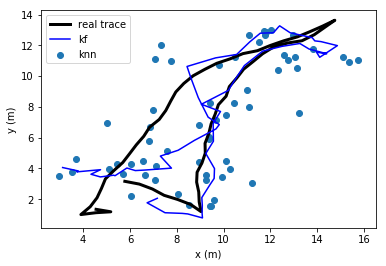

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
x_i = range(220, 280)
tr, = plt.plot(trace[x_i, 0]/100., trace[x_i, 1] /100., 'k-', linewidth=3)
#pf, = plt.plot(knn_pf_predictions[x_i, 0], knn_pf_predictions[x_i, 1], 'r-')
kf, = plt.plot(knn_kf_predictions[x_i, 0], knn_kf_predictions[x_i, 1], 'b-')
knn_ = plt.scatter(knn_predictions[x_i, 0] / 100., knn_predictions[x_i, 1] / 100.)

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend([tr,  kf, knn_], ["real trace",  "kf", "knn"])
plt.show()